In [1]:
import os
import sys
import copy
from pathlib import Path
from datetime import datetime
from collections import Counter
import watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummaryX import summary

In [2]:
#%load_ext pycodestyle_magic
#%%pycodestyle

In [3]:
if torch.cuda.is_available():
    print('GPU support: %s' % torch.cuda.get_device_name(0))
else:
    print('No GPU was detected!')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Torch device:', device)

GPU support: GeForce RTX 2080
Torch device: cuda:0


In [4]:
#%load_ext watermark
#%watermark --iversions

In [5]:
assert sys.version_info >= (3, 5)
assert torch.__version__ >= "1.4.0"

In [6]:
DICTIONARY_FULL = 'fr_wiktionary_full.csv'
DICTIONARY_FILE = 'fr_wiktionary_light.csv'

### AUDIO_DIR = 'audio/'
TIME_MAX = 2.0
MFCC_FREQS = 90
print('TIME_MAX:%d' % TIME_MAX)
print('MFCC_FREQS:%d' % MFCC_FREQS)


MFCC_DIR = 'mfcc_' + str(TIME_MAX) + '_' + str(MFCC_FREQS) + '/'

TARGET_PHONEMES_MAX = 20
ORDER = False

EPOCHS = 20
EPISODES = 5
print('EPOCHS:%d' % EPOCHS)
print('EPISODES:%d' % EPISODES)

CONV_LAYERS = 2
LSTM_LAYERS = 2

print('CONV_LAYERS:%d' % CONV_LAYERS)
print('LSTM_LAYERS:%d' % LSTM_LAYERS)
VALIDATION_SPLIT = 0.1

NB_TEST_SAMPLES = 1000
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

PATIENCE_MAX = 5
    
SPEAKERS = ['WikiLucas'] # 19545 mots => 90: n_tested:100, n_ok:60, n_ko:40
#SPEAKERS = ['Lepticed'] #6145 => n_tested:100, n_ok:51, n_ko:49
#SPEAKERS = ['WikiLucas', 'Lepticed'] # 25690
#SPEAKERS = ['Lyokoï'] # 9039 mots => n_tested:100, n_ok:62, n_ko:38
#SPEAKERS = ['WikiLucas', 'Lepticed','Lyokoï'] # 90 : n_ok:64, n_ko:36 , 40: n_ok:66, n_ko:34
#SPEAKERS = [] # 30000 mots => 40:n_ok:61, n_ko:39
#SPEAKERS = []

print('TARGET_PHONEMES_MAX:', TARGET_PHONEMES_MAX)
print('ORDER:', ORDER)
print('VALIDATION_SPLIT:', VALIDATION_SPLIT)
BATCH = 20
print('BATCH_SIZE:', BATCH)

TIME_MAX:2
MFCC_FREQS:90
EPOCHS:20
EPISODES:5
CONV_LAYERS:2
LSTM_LAYERS:2
NB_TEST_SAMPLES:1000
TARGET_PHONEMES_MAX: 20
ORDER: False
VALIDATION_SPLIT: 0.1
BATCH_SIZE: 20


In [7]:
PHONEMES = [
    # Voyelles
    'i', 'e', 'ɛ', 'a', 'ɑ', 'ɔ', 'o', 'u', 'y',
    'ø', 'œ', 'ə', 'ɛ̃', 'ɑ̃', 'ɔ̃', 'œ̃',
    # Semi-consonnes
    'j', 'w', 'ɥ',
    # Consonnes
    'p', 't', 'k', 'b', 'd', 'ɡ', 'f', 's', 'ʃ', 'v',
    'z', 'ʒ', 'l', 'ʁ', 'm', 'n', 'ɲ', 'ŋ',
]


def print_phonemes():
    i = 0
    for i in range(len(PHONEMES) + 2):
        if i == 0:
            print("' 0")
        elif i == 1:
            print('<SPACE> 1')
        else:
            print('%s %d' % (PHONEMES[i-2], i))

In [8]:
char_2_int_str = """
' 0
<SPACE> 1
i 2
e 3
ɛ 4
a 5
ɑ 6
ɔ 7
o 8
u 9
y 10
ø 11
œ 12
ə 13
ɛ̃ 14
ɑ̃ 15
ɔ̃ 16
œ̃ 17
j 18
w 19
ɥ 20
p 21
t 22
k 23
b 24
d 25
ɡ 26
f 27
s 28
ʃ 29
v 30
z 31
ʒ 32
l 33
ʁ 34
m 35
n 36
ɲ 37
ŋ 38
"""

char_2_int = {}
int_2_char = {}
for line in char_2_int_str.strip().split('\n'):
    ch, index = line.split()
    char_2_int[ch] = int(index)
    int_2_char[int(index)+1] = ch
int_2_char[2] = ' '

In [9]:
def get_phonemes(pronunciation):

    phonemes = []
    for i in range(len(pronunciation)):
        if i < len(pronunciation) - 1:
            if pronunciation[i] == '̃':
                continue
            if pronunciation[i+1] == '̃':
                if pronunciation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronunciation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronunciation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronunciation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronunciation[i]
        else:
            if pronunciation[i] == '̃':
                continue
            else:
                phoneme = pronunciation[i]
        phonemes.append(phoneme)
    return phonemes


def get_padded_phonemes(pronunciation, str_len_max):

    padded_phonemes = get_phonemes(pronunciation)
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes


def get_tk_padded_phonemes(pronunciation, str_len_max):

    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(char_2_int[phoneme])

    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)

    return np_array


assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6),
                      np.array([[22, 14, 24, 34,  0,  0]]))


def get_prononciation(padded_phonemes):

    prononciation = ''
    for padded_phoneme in padded_phonemes:
        if padded_phoneme == "'":
            break
        else:
            prononciation += padded_phoneme

    return prononciation


assert get_prononciation(['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]) == 'tɛ̃bʁ', 6

In [10]:
def get_string_to_numpy(string, nb_max_chars):

    if nb_max_chars < len(string):
        raise ValueError('must not happen: nb_max_chars:%d too small\
        for string:%s (%d letters)' % (nb_max_chars, string, len(string)))
        return ''

    np_string = np.zeros((nb_max_chars))
    for i in range(len(string)):
        np_string[i] = ord(string[i])

    return np_string


def get_string_from_numpy(np_string):

    string = ''
    for i in range(np_string.shape[0]):
        code = int(np_string[i])
        if code == 0:
            break
        else:
            string += chr(code)
    return string


assert get_string_from_numpy(get_string_to_numpy("tɛ̃bʁ", 6)) == "tɛ̃bʁ"

In [11]:
def get_audio_files_names(audio_files_str, speakers=[], verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        if audio_files_str.startswith('['):
            files_string = audio_files_str[2:-2]
        else:
            files_string = audio_files_str
        files_string += '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        audio_file_names2 = []
        for audio_file_name in audio_file_names:
            if not speakers:
                audio_file_names2.append(audio_file_name)
            else:
                for speaker in speakers:
                    if speaker in audio_file_name:
                        audio_file_names2.append(audio_file_name)
        audio_file_names = audio_file_names2
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names


assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("['a', 'b', 'c']") == ['a', 'b', 'c']
assert get_audio_files_names("['foo-a', 'bar-b']", ['bar']) == ['bar-b']
assert get_audio_files_names("['foo-a', 'bar-b', 'car-c', 'foo-d']",
                             ['bar', 'foo']) == ['foo-a', 'bar-b', 'foo-d']

In [12]:
allowed_IPA_letters = [
    'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 's', 't', 'u', 'v', 'w', 'y',
    'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
    'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'
]

verbose_IPA_letters = [
    ')', ')', '‿', '.', ' ', '͡', '-', 'ˈ', 'ː'
]
            

''' Retrieve the dataset
'''


def get_data(dict_file, audio_dir, n_max=sys.maxsize, n_max_phonemes=sys.maxsize, 
             speakers=[], index_min=0, index_max=sys.maxsize, verbose=False):

    df = pd.read_csv(dict_file, sep='\t')     
        
    # read 1 mfcc file to learn the maximum shape of the samples
    # in the directory
    audio_shape_t = 0 # should lead to 87
    audio_shape_d = 0 # should lead to 40 or 90

    #for index, row in df[df.Audio != '-'].iterrows():
    for index, row in df.loc[index_min:index_max, :].iterrows():
      
        audio_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        if verbose:
            print('Audio=*%s*' % row['Audio'])
        for wav_file in wav_files:
            if verbose:
                print('wav_file=*%s*' % wav_file)
            audio_file = wav_file.replace('.wav','.npy').replace(' ','_') 
            audio_filename = audio_dir + audio_file

            if os.path.exists(audio_filename):
                mfcc = np.load(audio_filename)
                audio_shape_t = max(audio_shape_t, mfcc.shape[1])
                audio_shape_d = mfcc.shape[0]
                break
            else:
                if verbose:
                    print('audio_file=*%s* not found !!!' % audio_file)
    if audio_shape_t == 0:
        print('audio_shape_t not found !!!' % audio_file)
        return 0

    # audio_shape_t=87 # if time==2.0
    # audio_shape_d=40 #
    print('audio_shape_t:%d', audio_shape_t)
    print('audio_shape_d:%d', audio_shape_d)

    n_max = df.shape[0]
    if index_max == sys.maxsize:
        index_max = n_max
    n_ok=0
    n_ko=0

    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, audio_shape_t, audio_shape_d))
    phonemess = np.zeros((n_max, n_max_phonemes))
    CHAR_MAX = 50
    motss = np.zeros((n_max, CHAR_MAX))
    prononciationss = np.zeros((n_max, CHAR_MAX))
    #mots = []
    #prononciations = []

    # iterate over the lines of the wanted slice (aka rows)
    for index, row in df.loc[index_min:index_max, :].iterrows(): 
    #for index, row in df.iterrows(): # sample() is used to shuffle data        

        audio_file = ''
        wav_files = get_audio_files_names(row['Audio'], speakers=speakers)
        # so far, take only first file (to be enhanced!!!)
        audio_file = wav_files[0].replace('.wav','.npy').replace(' ','_')
        
        if audio_file == '':
            continue

        audio_filename = audio_dir + audio_file
        if os.path.exists(audio_filename):
            mfcc = np.load(audio_filename)
            if verbose:
                print('mfcc.shape:', mfcc.shape)

            '''
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Mot'])
                except:
                    print('#')
                continue
            '''
            
            # add the mfcc in the mfccs table
            mfccs[n_ok,:,:] = mfcc.transpose()[:,:]

            # fetch the prononciation
            mot = row['Mot']
            prononciation = row['Prononciation']
            for s in verbose_IPA_letters:
                prononciation = prononciation.replace(s, '')
            
            phonemes = get_tk_padded_phonemes(prononciation, n_max_phonemes)

            # add the mfcc in the mfccs table
            phonemess[n_ok, :] = phonemes
            # mots.append(mot)
            # prononciations.append(prononciation)
            try:
                motss[n_ok:] = get_string_to_numpy(mot, CHAR_MAX)
                prononciationss[n_ok:] = get_string_to_numpy(prononciation, CHAR_MAX)
                n_ok += 1
                if n_ok > n_max - 1:
                    break
            except:
                print("error for mot=%s, mot or pronuciation is float!" % mot)
                n_ko += 1
        else:
            if verbose:
                print('file ko:', audio_file)
            n_ko += 1

    print('n_max:', n_max)
    print('n_ok:', n_ok)
    print('n_ko:', n_ko)

    # delete unused rows
    mfccs = mfccs[:n_ok, :, :]
    phonemess = phonemess[:n_ok]
    prononciationss = prononciationss[:n_ok]
    motss = motss[:n_ok]

    print('mfccs.shape:', mfccs.shape)
    print('phonemess.shape:', phonemess.shape)
    print('prononciationss.shape:', prononciationss.shape)
    print('motss.shape:', motss.shape)

    return n_ok, mfccs, phonemess, prononciationss, motss

In [13]:
def clean_data(source_file, dest_file, n_max_phonemes=sys.maxsize, speakers=[], shuffle=False, order=False, verbose=False):

    audio_dir = MFCC_DIR
    
    df = pd.read_csv(source_file, sep='\t')
    print('source_file shape:', df.shape)
    
    df = df.dropna()
    
    # only keep 'Mot', 'Prononciation' and 'Audio' columns
    df = df[['Mot', 'Prononciation', 'Audio']]
    
    # skip samples whose pronunciation contains too many phonemes
    df = df[df.Prononciation.str.len() <= n_max_phonemes]

    # skip samples whose pronunciation contains unknown phonemes
    df = df[~df['Prononciation'].isin(PHONEMES)]

    # skip samples not containing audio file names
    df = df[~df.Audio.str.startswith("[]")]

    # clean pronunciation
    # rows having a pronnuciation with "bad" caracter will be dropped
    # from the dataframe
    check_phonemes = True
    verbose = False
    if check_phonemes:
        indexes_to_drop = []
        bad_letters = {}
        for index, row in df.iterrows():
            prononciation = row['Prononciation']
            for s in verbose_IPA_letters:
                prononciation = prononciation.replace(s, '')
            # prononciation = merge_nasals(prononciation)
            for phoneme in prononciation:
                if phoneme not in allowed_IPA_letters:
                    if phoneme not in bad_letters.keys():
                        bad_letters[phoneme] = 0
                    bad_letters[phoneme] += 1
                    if verbose:
                        print('bad phoneme %s in [%s] /%s/'
                              % (phoneme, row['Mot'], row['Prononciation']))
                    indexes_to_drop.append(index)
                    break
            df.at[index, 'Prononciation'] = prononciation
        print('bad_letters=', bad_letters)
        df = df.drop(indexes_to_drop)
    
    # filter out samples from selected speakers, if any
    df2 = pd.DataFrame(columns=df.columns)
    if speakers:
        for speaker in speakers:
            df2 = pd.concat([df2, df[df['Audio'].str.contains(speaker)]])
        df = df2
        
        
    indexes_to_drop = []
    n_ok = 0
    n_ko = 0
    for index, row in df.iterrows():   

        audio_file = ''
        wav_files = get_audio_files_names(row['Audio'], speakers=speakers)
        # so far, take only first file (to be enhanced!!!)
        audio_file = wav_files[0].replace('.wav','.npy').replace(' ','_')
        
        if audio_file == '':
            print('pb for ', row['Mot'])
            continue

        audio_filename = audio_dir + audio_file
        if os.path.exists(audio_filename):
            #mfcc = np.load(audio_filename)
            #if verbose:
            #    print('mfcc.shape:', mfcc.shape)
            '''
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Mot'])
                except:
                    print('#')
                continue
            '''
        else:
            if verbose:
                print('file ko:', audio_file)
            indexes_to_drop.append(index)
            n_ko += 1
    print('n_ok:', n_ok)
    df = df.drop(indexes_to_drop)
        
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    
    # reindex the dataframe by the Pronunciation column lenght
    if order:
        s = df.Prononciation.str.len().sort_values(ascending=True).index
        df = df.reindex(s)
        
    df.to_csv(dest_file, index=False, sep='\t')
    
    print('dest_file shape:', df.shape, '\n')
    
    return df.shape[0]
    #print("df[df.Mot=='tonton']", df[df.Mot=='tonton'])

clean_data(DICTIONARY_FULL, DICTIONARY_FILE, TARGET_PHONEMES_MAX, speakers=SPEAKERS, shuffle=True, order=False) 

source_file shape: (1503707, 8)
bad_letters= {'(': 374, 'é': 1, 'ɹ': 1, 'r': 30, 'ɪ': 11, 'x': 3, '_': 1, 'ʎ': 1, 'ʊ': 3, 'ʔ': 13, 'h': 31, 'ˌ': 1, 'ʌ': 1, '·': 13, 'ε': 4, '/': 1, '̥': 8, 'ʀ': 1, ':': 1, 'ʰ': 3, 'ᵊ': 4, '…': 4, '͂': 1, 'ẽ': 1, '̩': 2, 'ɒ': 1, ',': 2, 'ǀ': 1, '̯': 2}
n_ok: 0
dest_file shape: (28464, 3) 



28464

In [14]:
def get_ann_data(n, n_wished_test, mfccs, phonemes, mots, verbose=False):
    
    n_wished_train = n - n_wished_test
    n_train_ratio = int(n_wished_train/n_wished_test)
    print('n_train_ratio:%d',n_train_ratio)

    # following code is somehow complex "just" to have the option to 
    # preserve increased-length order in both the training and
    # tests data.

    # delete 1 row every n_train_ratio rows
    mfccs_train = np.delete(mfccs, list(range(0, mfccs.shape[0], n_train_ratio)), axis=0)
    phonemes_train = np.delete(phonemes, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
    prononciations_train = np.delete(prononciations, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
    mots_train = np.delete(mots, list(range(0, mots.shape[0], n_train_ratio)), axis=0)
    X_train = mfccs_train
    Y_train = phonemes_train

    # keep 1 row every n_train_ratio
    mfccs_test = mfccs[0::n_train_ratio]
    phonemes_test = phonemes[0::n_train_ratio]
    prononciations_test= prononciations[0::n_train_ratio]
    mots_test = mots[0::n_train_ratio]
    X_test = mfccs_test
    Y_test = phonemes_test

    # get ride of few samples in order to respect the number of
    # wanted test samples (e.g. decimal "round" number like 100)
    # which will allow for direct estimation of percentages.
    if mfccs_test.shape[0] - NB_TEST_SAMPLES > 0:
        mfccs_test = mfccs_test[0:NB_TEST_SAMPLES]
        phonemes_test = phonemes_test[0:NB_TEST_SAMPLES]
        mots_test = mots_test[0:NB_TEST_SAMPLES]
        X_test = mfccs_test
        Y_test = phonemes_test
    
    if verbose:
        NB_TRAINING_SAMPLES = X_train.shape[0]
        print('NB_TRAINING_SAMPLES:%d' % NB_TRAINING_SAMPLES)
        print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

    x_train_mean = X_train.mean()
    x_train_std = X_train.std()
    X_train -= x_train_mean
    X_train /= x_train_std

    X_test -= x_train_mean
    X_test /= x_train_std
    
    return X_train, X_test, Y_train, Y_test, mots_test, prononciations_test

In [15]:
FIRST_TIME_EVER = True

In [16]:
# Define the model
class ASR(nn.Module):
  def __init__(self, T, D, C):
    
    super(ASR, self).__init__()
    self.T = T
    self.D = D
    self.K = C
    
    if FIRST_TIME_EVER:
        self.first_time = True
        FIRST_TIME_EVER == False

    
    #torch.nn.Conv1d(in_channels, out_channels, kernel_size, 
    #                stride=1, padding=0, dilation=1, groups=1, 
    #                bias=True, padding_mode='zeros')
    if CONV_LAYERS == 0:
        print('CONV_LAYERS=% should not happen' % CONV_LAYERS)
    if CONV_LAYERS >= 1:
        self.layers = CONV_LAYERS
        self.conv_out = 128
        #self.conv1 = nn.Conv1d(self.D, self.conv_out, 3, stride=1, padding=1) 
        self.conv1 = nn.Conv1d(self.D, self.conv_out, 3, stride=1, padding=1) 
        #self.pool1 = nn.MaxPool1d(2)
        self.bn1 = nn.BatchNorm1d(self.conv_out)
    if CONV_LAYERS >= 2:
        self.conv_in = self.conv_out
        self.conv_out = self.conv_in * 2
        self.conv2 = nn.Conv1d(self.conv_in, self.conv_out, 3, stride=1, padding=1)
        #self.pool2 = nn.MaxPool1d(2)
        self.bn2 = nn.BatchNorm1d(self.conv_out)
    if CONV_LAYERS >= 3:
        self.conv_in = self.conv_out 
        self.conv_out = self.conv_in * 2
        self.conv3 = nn.Conv1d(self.conv_in, self.conv_out, 3, stride=1, padding=1)
        #self.pool3 = nn.MaxPool1d(2)
        self.bn3 = nn.BatchNorm1d(self.conv_out)
    if CONV_LAYERS >= 4:
        print('CAN NOT ALLOW CONV_LAYERS=%, ALLOCATED:3' % CONV_LAYERS)
    
    self.lstm_out = 512
    self.lstm = nn.LSTM(input_size=self.conv_out, hidden_size=self.lstm_out, num_layers=LSTM_LAYERS,
                        dropout=0.5, bidirectional=True, 
                        batch_first=True,
                       )    
    self.bn_lstm = nn.BatchNorm1d(self.T)
    
    self.fc = nn.Linear(self.lstm_out*2, self.K)
    
    
    
  
  def forward(self, X, verbose=True):
        
    global FIRST_TIME
    # embedding layer
    # turns word indexes into word vectors
    data = X

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    if verbose and self.first_time:
        print('')
        print('Data shapes:')
        print('before permute data.shape:', data.shape)    
    data = data.permute(0, 2, 1)
    
    if CONV_LAYERS >= 1:
        if verbose and self.first_time:
            print('before conv1 data.shape:', data.shape)
        data = self.conv1(data)
        data = self.bn1(data)    
        if verbose and self.first_time:
            print('before relu1 data.shape:', data.shape)
        data = torch.relu(data)
        #data = self.pool1(data)
    
    if CONV_LAYERS >= 2:
        if verbose and self.first_time:
            print('before conv2 data.shape:', data.shape)
        data = self.conv2(data)
        data = self.bn2(data)    
        if verbose and self.first_time:
            print('before relu2 data.shape:', data.shape)
        data = torch.relu(data)
        #data = self.pool2(data)
        
    if CONV_LAYERS >= 3:
        if verbose and self.first_time:
            print('before conv3 data.shape:', data.shape)
        data = self.conv3(data)
        data = self.bn3(data)    
        if verbose and self.first_time:
            print('before relu3 data.shape:', data.shape)
        data = nn.functional.relu(data)
        #data = self.pool3data)
        
    if verbose and self.first_time:
        print('before permute data.shape:', data.shape)    
    data = data.permute(0, 2, 1)

    if verbose and self.first_time:
        print('before bi-lstm data.shape:', data.shape)
    data, states = self.lstm(data)
    
    data = self.bn_lstm(data)
    
    # max pool
    #out, _ = torch.max(out, self.K)
    if verbose and self.first_time:
        print('before fc data.shape::', data.shape, '\n')
    # final dense layer
    data = self.fc(data)
    
    if verbose and self.first_time:
        print('after fc data.shape::', data.shape, '\n')
    
    self.first_time = False
    
    return data

In [17]:
def get_training_sizes(mfccs, phonemes):


    N = mfccs.shape[0]
    print('N:%d (Number of samples)', N)
    
    T = mfccs.shape[1]
    print('T:%d (Time units)', T)

    assert mfccs.shape[2] == MFCC_FREQS
    D = mfccs.shape[2]
    print('D:%d (Data units (frequency samples))', D)

    input_length = np.zeros([N])
    for i in range(N):
        input_length[i] = 87 #43 # 87
    print('input_length[0:2]:', input_length[0:2])
    print('input_length.shape', input_length.shape)

    assert phonemes.shape[1] == TARGET_PHONEMES_MAX
    label_length = np.zeros([N])
    for i in range(N):
        label_length[i] = phonemes.shape[1]
    print('label_length[0:2]:', label_length[0:2])

    C = len(char_2_int.keys()) + 1
    
    return N, T, D, C, input_length, label_length


In [18]:
def get_model(T, D, C):

    model = ASR(T, D, C)
    model.to(device)
    
    #import nn.CrossEntropyLoss
    # Loss and optimizer
    criterion = nn.CTCLoss(blank=1).to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-07)
    optimizer = torch.optim.Adam(model.parameters())
    
    return model, criterion, optimizer

In [19]:
# A function to encapsulate the training loop
def fit(model, criterion, optimizer,
        X_train, Y_train, input_lenghts1, target_lenghts1, 
        X_test, Y_test, input_lenghts2, target_lenghts2, 
        epochs=10, verbose=False):
    
    if verbose:
        print('X_train.shape: ', X_train.shape)        
        print('Y_train.shape: ', Y_train.shape)
        print('input_lenghts1.shape: ', input_lenghts1.shape)
        print('target_lenghts1.shape: ', target_lenghts1.shape)
        print('X_test.shape: ', X_test.shape)        
        print('Y_test.shape: ', Y_test.shape)
        print('input_lenghts2.shape: ', input_lenghts2.shape)
        print('target_lenghts2.shape: ', target_lenghts2.shape)
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    #train_accs = np.zeros(epochs)
    #test_accs = np.zeros(epochs)
    
    test_loss_min = 0.
    patience = 0
    
    for it in range(epochs):
        #print('it:', it)
        t0 = datetime.now()
        train_loss = []
        

        for b in range(int(X_train.shape[0]/BATCH)):
            #for inputs, targets in train_iter:
            #print('['+str(b*BATCH)+':'+str((b+1)*BATCH)+']')
            
            inputs = torch.from_numpy(X_train[b*BATCH:(b+1)*BATCH,:,:]).float()
            #print('inputs shape:',inputs.shape)
            targets = torch.from_numpy(Y_train[b*BATCH:(b+1)*BATCH,:]).float()
            input_lenghts = input_lenghts1[b*BATCH:(b+1)*BATCH]
            #print('input_lenghts shape:',input_lenghts.shape)
            target_lenghts = target_lenghts1[b*BATCH:(b+1)*BATCH]
      
            #print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
            #targets = targets.view(-1, 1).float()
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass !!!!!!!!!!!!
            outputs = model(inputs)
 
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            
            loss1 = criterion(probs, targets, input_lenghts, target_lenghts)
        
            # Backward and optimize
            loss1.backward()
            optimizer.step()

            train_loss.append(loss1.item())
        
        #print("it:",it," training done")
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        test_loss = []
        #for inputs, targets in test_iter:
        for b in range(int(X_test.shape[0]/BATCH)):
            inputs = torch.from_numpy(X_test[b*BATCH:(b+1)*BATCH,:,:]).float()
            targets = torch.from_numpy(Y_test[b*BATCH:(b+1)*BATCH,:]).float()
            inputs, targets = inputs.to(device), targets.to(device)
            input_lenghts = input_lenghts2[b*BATCH:(b+1)*BATCH]
            target_lenghts = target_lenghts2[b*BATCH:(b+1)*BATCH]
      
            #targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            loss2 = criterion(probs, targets, input_lenghts, target_lenghts)
            test_loss.append(loss2.item())
        test_loss = np.mean(test_loss)

        '''
        train_accs_b = []
        for b in range(int(X_train.shape[0]/BATCH)):
            X_train_b = X_train[b*BATCH:(b+1)*BATCH,:,:]
            Y_train_b = Y_train[b*BATCH:(b+1)*BATCH,:]
            train_acc_b, _, _, _, _, _ = test(model, X_train_b, Y_train_b)
            train_accs_b.append(train_acc_b)
        train_acc = np.mean(train_accs_b)
        
        test_accs_b = []
        for b in range(int(X_test.shape[0]/BATCH)):
            X_test_b = X_test[b*BATCH:(b+1)*BATCH,:,:]
            Y_test_b = Y_test[b*BATCH:(b+1)*BATCH,:]
            test_acc_b, _, _, _, _, _ = test(model, X_test_b, Y_test_b)
            test_accs_b.append(test_acc_b)
        test_acc = np.mean(test_accs_b)
        '''
        
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        #train_accs[it] = train_acc
        #test_accs[it] = test_acc
        
        dt = datetime.now() - t0
        #print('epoch:%d/%d (%ss) train_loss:%.2f, test_loss:%.2f, train_acc:%.2f, test_acc:%.2f'
        #      % (it+1, epochs, dt.seconds, train_loss, test_loss, train_acc, test_acc))
        print('epoch:%d/%d (%ss) train_loss:%.2f, test_loss:%.2f'
              % (it+1, epochs, dt.seconds, train_loss, test_loss))

        if it==0:
            test_loss_min = test_loss
            torch.save(model.state_dict(), 'wav2phoneme_pytorch.torch')
            #print('INIT test_loss_min:%f', test_loss_min)
        elif test_loss < test_loss_min:
            test_loss_min = test_loss
            torch.save(model, 'wav2phoneme_pytorch.torch')
            print('NEW BEST test_loss:%.2f' % test_loss_min)
            patience = 0
        else:
            #print('(old) test_loss_min:%f', test_loss_min)
            patience += 1
            if patience == PATIENCE_MAX:
                print('Patience max reached, break')
                break
                
    # return stored model, which is the best one
    model = torch.load('wav2phoneme_pytorch.torch')

    return model, train_losses[0:it+1], test_losses[0:it+1]

In [20]:
def train(model, criterion, optimizer, X_train, Y_train, input_length, label_length):
    
    test_split = (1. -  VALIDATION_SPLIT)
    N_train = int(X_train.shape[0] * test_split)
    N_test = X_train.shape[0] - N_train
    X_train1 = X_train[0:N_train]
    Y_train1 = Y_train[0:N_train]
    input_lenghts_train1 = torch.from_numpy(input_length[0:N_train]).short()
    target_lenghts_train1 = torch.from_numpy(label_length[0:N_train]).short()
    X_train2 = X_train[N_train:]
    Y_train2 = Y_train[N_train:]
    input_lenghts_train2= torch.from_numpy(input_length[N_train:]).short()
    target_lenghts_train2 = torch.from_numpy(label_length[N_train:]).short()

    print("test_samples:%d, eval_samples:%d" % (X_train1.shape[0], X_train2.shape[0]))
    
    t0 = datetime.now()

    model, train_losses, test_losses = fit(
        model, criterion, optimizer, 
        X_train1, Y_train1, input_lenghts_train1, target_lenghts_train1,
        X_train2, Y_train2, input_lenghts_train2, target_lenghts_train2, 
        EPOCHS)

    t1 = datetime.now()
    training_duration = t1 - t0
    print('training_duration', training_duration)
    
    return model, train_losses, test_losses

In [21]:
def display_learning_curves(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    _ = plt.plot(train_losses, label='train loss')
    _ = plt.plot(test_losses, label='test loss')
    _ = plt.legend()
    _ = plt.show()

In [22]:
def decode_predictions(output, labels, allow_consecutive=False, verbose=False):
    #print('output.shape:', output.shape)
    arg_maxes = torch.argmax(output, dim=2)
    #print('arg_maxes:',arg_maxes)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = ''
        target = ''
        previous_letter = '@'
        if verbose:
            print('i:',i)
            print('args:',args)
            print('labels[i]:',labels[i])
            print('labels[i][:label_lengths[i]]:', labels[i][:int(label_lengths[i])])
        
        for j, index_ in enumerate(labels[i]):
            index = index_.item()
            target_letter = int_2_char[index+1]
            if verbose:
                print('target_letter:%s' % target_letter)
            if target_letter != ' ' and target_letter !="'":
                target += target_letter
        
        if verbose:
            print('target:',target)
        targets.append(target)
        for j, index_ in enumerate(args):
            index = index_.item()
            predicted_letter = int_2_char[index+1]
            if verbose:
                print('letter:%s' % predicted_letter)
            if predicted_letter != ' ' and predicted_letter !="'" and predicted_letter != previous_letter:
                decode += predicted_letter
                previous_letter = predicted_letter
        if verbose:
            print("decoded:", decode)
        decodes.append(decode)
    return decodes, targets

In [23]:
def test(model, X_test, Y_test, output_df=False, df_results=None, mots_test=None, prononciations_test=None, verbose1=False, verbose2=False):
    
    n = X_test.shape[0]
    
    inputs = torch.from_numpy(X_test[0:n]).float()
    labels = torch.from_numpy(Y_test[0:n]).float()
    
    inputs, targets = inputs.to(device), labels.to(device)
    predicted = model(inputs)
    phonemess, target_phonemess = decode_predictions(predicted, labels)

    n_tested = 0
    n_ok = 0
    n_ko = 0

    if verbose2:
        debug_str = '[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>'

    targets = []
    predictions = []
    debug_targets_vs_predictions = []

    if output_df:
        try: 
            if df_results == None:
                cols = ['Mot', 'Prononciation_Wiktionnaire', 'Prononciation_Prédite', 'Résultat']
                df_results = pd.DataFrame(columns=cols)
        except:
            never_mind = True # goes here when df_results is not empty
    else:
        df_results = None
    
    for i in range(X_test.shape[0]):
        phonemes = ''
        if output_df:
            mot = get_string_from_numpy(mots_test[i])
            prononciation = get_string_from_numpy(prononciations_test[i])
        if verbose2:
            if output_df:
                debug_str = '[' + mot + ']' + '/' + prononciation + '/ : '
            else:
                debug_str = ''
                
        prediction_res = True

        phonemes = phonemess[i]
        target_phonemes = target_phonemess[i]
        
        if verbose2:
            debug_str += '/' + target_phonemes + '/ vs '

        #targets.append(prononciation) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        targets.append(target_phonemes)
        predictions.append(phonemes)
        if verbose2:
                debug_str += '/' + phonemes + '/'
        n_tested += 1
        if phonemes == target_phonemes:
            n_ok += 1
        else:
            n_ko += 1
            prediction_res = False
        if output_df:
            df_results = df_results.append({'Mot': mot, 
                                            'Prononciation_Wiktionnaire': prononciation, 
                                            'Prononciation_Prédite': phonemes, 
                                            'Résultat': prediction_res}, 
                                           ignore_index=True)

    ok_out_of_100 = round(n_ok/n_tested*100)
    ko_out_of_100 = round(n_ko/n_tested*100)
    accuracy = n_ok/n_tested
    
    if verbose1:
        #print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))
        #print()
        print('Prediction results: %d%% ok and %d%% ko (out of %d samples tested)' % \
              (ok_out_of_100, ko_out_of_100, n_tested))
    
    return accuracy, ok_out_of_100, ko_out_of_100, targets, predictions, df_results


Data shapes:
before permute data.shape: torch.Size([1, 87, 90])
before conv1 data.shape: torch.Size([1, 90, 87])
before relu1 data.shape: torch.Size([1, 128, 87])
before conv2 data.shape: torch.Size([1, 128, 87])
before relu2 data.shape: torch.Size([1, 256, 87])
before permute data.shape: torch.Size([1, 256, 87])
before bi-lstm data.shape: torch.Size([1, 87, 256])
before fc data.shape:: torch.Size([1, 87, 1024]) 

after fc data.shape:: torch.Size([1, 87, 40]) 

            Kernel Shape   Output Shape   Params  Mult-Adds
Layer                                                      
0_conv1     [90, 128, 3]   [1, 128, 87]    34688    3006720
1_bn1              [128]   [1, 128, 87]      256        128
2_conv2    [128, 256, 3]   [1, 256, 87]    98560    8552448
3_bn2              [256]   [1, 256, 87]      512        256
4_lstm                 -  [1, 87, 1024]  9453568    9437184
5_bn_lstm           [87]  [1, 87, 1024]      174         87
6_fc          [1024, 40]    [1, 87, 40]    41000     

/home/xavier/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:3/20 (48s) train_loss:0.15, test_loss:0.16
NEW BEST test_loss:0.16
epoch:4/20 (48s) train_loss:0.13, test_loss:0.16
NEW BEST test_loss:0.16
epoch:5/20 (48s) train_loss:0.11, test_loss:0.15
NEW BEST test_loss:0.15
epoch:6/20 (48s) train_loss:0.10, test_loss:0.14
NEW BEST test_loss:0.14
epoch:7/20 (48s) train_loss:0.09, test_loss:0.13
NEW BEST test_loss:0.13
epoch:8/20 (49s) train_loss:0.08, test_loss:0.13
NEW BEST test_loss:0.13
epoch:9/20 (50s) train_loss:0.08, test_loss:0.14
epoch:10/20 (48s) train_loss:0.07, test_loss:0.13
NEW BEST test_loss:0.13
epoch:11/20 (50s) train_loss:0.07, test_loss:0.13
NEW BEST test_loss:0.13
epoch:12/20 (51s) train_loss:0.06, test_loss:0.13
epoch:13/20 (49s) train_loss:0.06, test_loss:0.13
epoch:14/20 (48s) train_loss:0.06, test_loss:0.13
epoch:15/20 (48s) train_loss:0.05, test_loss:0.13
NEW BEST test_loss:0.13
epoch:16/20 (48s) train_loss:0.05, test_loss:0.14
epoch:17/20 (49s) train_loss:0.05, test_loss:0.13
epoch:18/20 (48s) train_loss:0.05, test_l

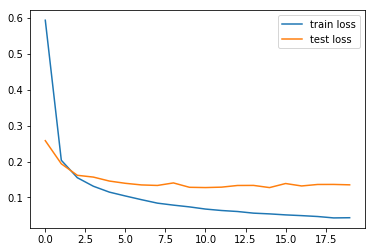

Prediction results: 68% ok and 32% ko (out of 1000 samples tested)
EPISODE:1
source_file shape: (1503707, 8)
bad_letters= {'(': 374, 'é': 1, 'ɹ': 1, 'r': 30, 'ɪ': 11, 'x': 3, '_': 1, 'ʎ': 1, 'ʊ': 3, 'ʔ': 13, 'h': 31, 'ˌ': 1, 'ʌ': 1, '·': 13, 'ε': 4, '/': 1, '̥': 8, 'ʀ': 1, ':': 1, 'ʰ': 3, 'ᵊ': 4, '…': 4, '͂': 1, 'ẽ': 1, '̩': 2, 'ɒ': 1, ',': 2, 'ǀ': 1, '̯': 2}
n_ok: 0
dest_file shape: (28464, 3) 

batch:%d 0
audio_shape_t:%d 87
audio_shape_d:%d 90
n_max: 28464
n_ok: 28464
n_ko: 0
mfccs.shape: (28464, 87, 90)
phonemess.shape: (28464, 20)
prononciationss.shape: (28464, 50)
motss.shape: (28464, 50)
data_import_duration 0:00:32.468939
n_train_ratio:%d 27
N:%d (Number of samples) 27409
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 90
input_length[0:2]: [87. 87.]
input_length.shape (27409,)
label_length[0:2]: [20. 20.]
test_samples:24668, eval_samples:2741

Data shapes:
before permute data.shape: torch.Size([20, 87, 90])
before conv1 data.shape: torch.Size([20, 90, 87])
before re

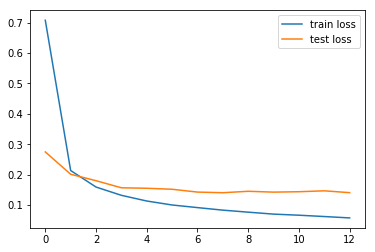

Prediction results: 63% ok and 37% ko (out of 1000 samples tested)
EPISODE:2
source_file shape: (1503707, 8)
bad_letters= {'(': 374, 'é': 1, 'ɹ': 1, 'r': 30, 'ɪ': 11, 'x': 3, '_': 1, 'ʎ': 1, 'ʊ': 3, 'ʔ': 13, 'h': 31, 'ˌ': 1, 'ʌ': 1, '·': 13, 'ε': 4, '/': 1, '̥': 8, 'ʀ': 1, ':': 1, 'ʰ': 3, 'ᵊ': 4, '…': 4, '͂': 1, 'ẽ': 1, '̩': 2, 'ɒ': 1, ',': 2, 'ǀ': 1, '̯': 2}
n_ok: 0
dest_file shape: (28464, 3) 

batch:%d 0
audio_shape_t:%d 87
audio_shape_d:%d 90
n_max: 28464
n_ok: 28464
n_ko: 0
mfccs.shape: (28464, 87, 90)
phonemess.shape: (28464, 20)
prononciationss.shape: (28464, 50)
motss.shape: (28464, 50)
data_import_duration 0:00:32.349795
n_train_ratio:%d 27
N:%d (Number of samples) 27409
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 90
input_length[0:2]: [87. 87.]
input_length.shape (27409,)
label_length[0:2]: [20. 20.]
test_samples:24668, eval_samples:2741

Data shapes:
before permute data.shape: torch.Size([20, 87, 90])
before conv1 data.shape: torch.Size([20, 90, 87])
before re

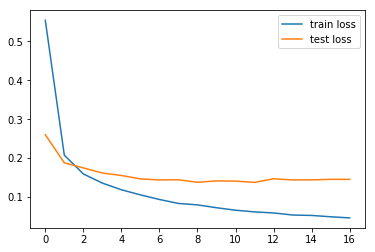

Prediction results: 66% ok and 34% ko (out of 1000 samples tested)
EPISODE:3
source_file shape: (1503707, 8)
bad_letters= {'(': 374, 'é': 1, 'ɹ': 1, 'r': 30, 'ɪ': 11, 'x': 3, '_': 1, 'ʎ': 1, 'ʊ': 3, 'ʔ': 13, 'h': 31, 'ˌ': 1, 'ʌ': 1, '·': 13, 'ε': 4, '/': 1, '̥': 8, 'ʀ': 1, ':': 1, 'ʰ': 3, 'ᵊ': 4, '…': 4, '͂': 1, 'ẽ': 1, '̩': 2, 'ɒ': 1, ',': 2, 'ǀ': 1, '̯': 2}
n_ok: 0
dest_file shape: (28464, 3) 

batch:%d 0
audio_shape_t:%d 87
audio_shape_d:%d 90
n_max: 28464
n_ok: 28464
n_ko: 0
mfccs.shape: (28464, 87, 90)
phonemess.shape: (28464, 20)
prononciationss.shape: (28464, 50)
motss.shape: (28464, 50)
data_import_duration 0:00:31.886562
n_train_ratio:%d 27
N:%d (Number of samples) 27409
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 90
input_length[0:2]: [87. 87.]
input_length.shape (27409,)
label_length[0:2]: [20. 20.]
test_samples:24668, eval_samples:2741

Data shapes:
before permute data.shape: torch.Size([20, 87, 90])
before conv1 data.shape: torch.Size([20, 90, 87])
before re

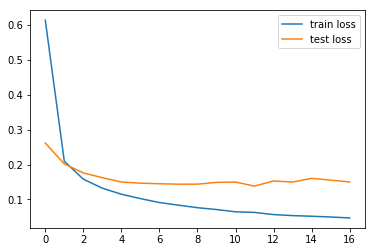

Prediction results: 63% ok and 37% ko (out of 1000 samples tested)
EPISODE:4
source_file shape: (1503707, 8)
bad_letters= {'(': 374, 'é': 1, 'ɹ': 1, 'r': 30, 'ɪ': 11, 'x': 3, '_': 1, 'ʎ': 1, 'ʊ': 3, 'ʔ': 13, 'h': 31, 'ˌ': 1, 'ʌ': 1, '·': 13, 'ε': 4, '/': 1, '̥': 8, 'ʀ': 1, ':': 1, 'ʰ': 3, 'ᵊ': 4, '…': 4, '͂': 1, 'ẽ': 1, '̩': 2, 'ɒ': 1, ',': 2, 'ǀ': 1, '̯': 2}
n_ok: 0
dest_file shape: (28464, 3) 

batch:%d 0
audio_shape_t:%d 87
audio_shape_d:%d 90
n_max: 28464
n_ok: 28464
n_ko: 0
mfccs.shape: (28464, 87, 90)
phonemess.shape: (28464, 20)
prononciationss.shape: (28464, 50)
motss.shape: (28464, 50)
data_import_duration 0:00:32.789380
n_train_ratio:%d 27
N:%d (Number of samples) 27409
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 90
input_length[0:2]: [87. 87.]
input_length.shape (27409,)
label_length[0:2]: [20. 20.]
test_samples:24668, eval_samples:2741

Data shapes:
before permute data.shape: torch.Size([20, 87, 90])
before conv1 data.shape: torch.Size([20, 90, 87])
before re

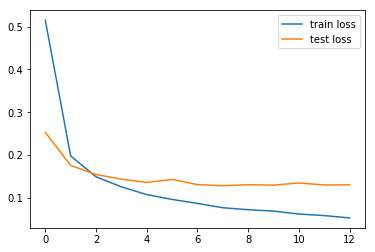

Prediction results: 67% ok and 33% ko (out of 1000 samples tested)


In [24]:
# Main loop

print(summary(ASR(87, MFCC_FREQS, 40), torch.zeros(1, 87, MFCC_FREQS)))
print('')
print('#############################################')
print('')

n_oks = np.zeros(EPISODES)
df_results = None

for episode in range(EPISODES):

    print('EPISODE:%d' % episode)

    n_samples = clean_data(DICTIONARY_FULL, DICTIONARY_FILE, TARGET_PHONEMES_MAX, 
                           speakers=SPEAKERS, shuffle=True, order=False) 
    
    T = 87
    D = MFCC_FREQS
    C = len(char_2_int.keys()) + 1
    
    model, criterion, optimizer = get_model(T, D, C)
    
    # Given that audio files may take a lot of memory, split the available
    # data in multiple batches in order to avoid loading them all at the
    # same time in memory    
    batch_nb = 1
    batch_size = n_samples//batch_nb
    
    
    for b in range(batch_nb):
        n_min = b * batch_size
        n_max = (b+1) * batch_size - 1
        print('batch:%d', b)
        t0 = datetime.now()
        n, mfccs, phonemes, prononciations, mots = get_data(DICTIONARY_FILE,
                                                            audio_dir=MFCC_DIR, 
                                                            n_max=n_samples,
                                                            n_max_phonemes=TARGET_PHONEMES_MAX,
                                                            speakers=SPEAKERS,
                                                            index_min=n_min,
                                                            index_max=n_max)
        
        t1 = datetime.now()
        data_import_duration = t1 - t0
        print('data_import_duration', data_import_duration)
    
        X_train, X_test, Y_train, Y_test, mots_test, prononciations_test = get_ann_data(n, 
                                                                                        NB_TEST_SAMPLES//batch_nb, 
                                                                                        mfccs, phonemes, 
                                                                                        mots)

        N, T, D, C, input_length, label_length = get_training_sizes(X_train, Y_train)

        model, train_losses, test_losses = train(model, criterion, optimizer, 
                                                 X_train, Y_train, input_length, label_length)

        display_learning_curves(train_losses, test_losses)

    # perform predictions
    accuracy, n_ok, n_ko, targets, predictions, df_results = test(model, 
                                                                  X_test, Y_test,
                                                                  output_df = True, df_results=None, 
                                                                  mots_test = mots_test, 
                                                                  prononciations_test = prononciations_test,
                                                                  verbose1 = True)
    n_oks[episode] = n_ok

In [25]:
print(n_oks)
print("percentages of words OK:", n_oks.mean())
print("standard deviation of words OK:", n_oks.std())

[68. 63. 66. 63. 67.]
percentages of words OK: 65.4
standard deviation of words OK: 2.0591260281974


In [26]:
def unit_test(model, n_mots, X_test, Y_test, mots_test, prononciations_test):

    unit_inputs = torch.from_numpy(X_test[0:n_mots]).float()
    unit_labels = torch.from_numpy(Y_test[0:n_mots]).float()
    unit_inputs, unit_targets = unit_inputs.to(device), unit_labels.to(device)
    unit_mots= [ get_string_from_numpy(mot) for mot in mots_test[0:n_mots] ]
    #unit_prononciations= [ get_string_from_numpy(mot) for mot in prononciations_test[0:n_mots] ]
    print('unit_mots:          ', unit_mots)
    #print('unit_prononciations:', unit_prononciations)
    predicted_phonemess, target_phonemess = decode_predictions(model(unit_inputs), unit_targets, verbose=False)
    print('target_phonemes:    ', target_phonemess)
    print('predicted_phonemes: ', predicted_phonemess)
    
unit_test(model, 3, X_test, Y_test, mots_test, prononciations_test)

unit_mots:           ['cerf-volant', 'frimant', 'crevoter']
target_phonemes:     ['sɛʁvɔlɑ̃', 'fʁimɑ̃', 'kʁəvɔte']
predicted_phonemes:  ['sɛʁvɔlɑ̃', 'fʁimɑ̃', 'kʁəvɔte']


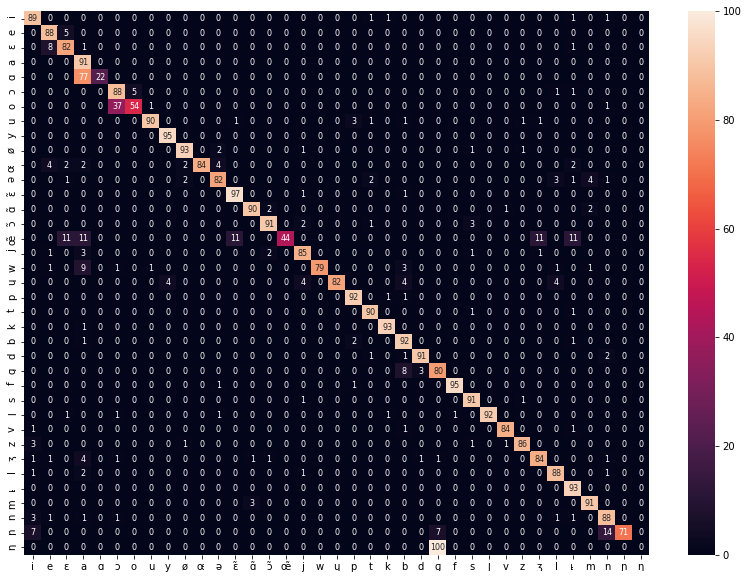

<Figure size 432x288 with 0 Axes>

In [27]:
# create a copy of char_2_int without \' and <SPACE>
char_2_int2 = char_2_int.copy()
del char_2_int2["'"]
del char_2_int2["<SPACE>"]

counting_bad_couples = Counter({})
counting_bad_letters = Counter({})
n_bad_letters = 0

# fill a confusion matrix 
confusion_array = np.zeros((len(char_2_int),len(char_2_int)))
for i in range(len(targets)):
    target_phonemes = get_phonemes(targets[i])
    prediction_phonemes = get_phonemes(predictions[i])
    for j in range(len(target_phonemes)):
        letter_targeted = target_phonemes[j]
        if j < len(prediction_phonemes):
            letter_predicted = prediction_phonemes[j]
            letter_targeted_index = char_2_int[letter_targeted]
            letter_predicted_index = char_2_int[letter_predicted]
            try:
                confusion_array[letter_targeted_index, letter_predicted_index] += 1
            except:
                print('error target letter:%s (%s), prediction:%s, predicted letter (in %s)' %\
                (letter_targeted, targets[i], letter_predicted, predictions[i]))
            if letter_predicted != letter_targeted : 
                key1 = letter_targeted
                counting_bad_letters[key1] += 1
                key2 = letter_predicted + '-' + letter_targeted
                counting_bad_couples[key2] += 1
                n_bad_letters += 1

for t in range(confusion_array.shape[0]):
    sum = 0
    for p in range(confusion_array.shape[1]):
        sum += confusion_array[t, p]
    for p in range(confusion_array.shape[1]):
        if sum > 0:
            confusion_array[t, p] = int(confusion_array[t, p]/sum*100)
            
# display the confusion matrix
# create a copy of char map without first two chars (' and SPACE)
char_2_int2 = char_2_int.copy()
del char_2_int2["'"]
del char_2_int2["<SPACE>"]
# display the confusion matrix without first 2 rows and first 2 colums
df_cm = pd.DataFrame(confusion_array[2:,2:], index = [i for i in char_2_int2],
                  columns = [i for i in char_2_int2])
_ = plt.figure(figsize = (14,10))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g')
_ = plt.show()
plt.savefig('wav2phoneme_pytorch_jupyter.png')

In [28]:
_counting_bad_couples = Counter({})

for key in counting_bad_couples.keys():
    _counting_bad_couples[key] = int(counting_bad_couples[key]/n_bad_letters*10000)/100

print("percentage of the 10 top_most errors:")
print('')
print("[(predicted_phoneme-target_phoneme), percentage]")
print(_counting_bad_couples.most_common(10))

percentage of the 10 top_most errors:

[(predicted_phoneme-target_phoneme), percentage]
[('ɔ-o', 4.65), ('ɛ-e', 3.46), ('e-ɛ', 2.27), ('o-ɔ', 1.91), ('a-ɑ', 1.67), ('ɑ̃-m', 1.19), ('b-ɡ', 1.07), ('ʁ-i', 0.95), ('a-j', 0.95), ('i-z', 0.83)]


In [29]:
_counting_bad_letters = Counter({})

for key in counting_bad_letters.keys():
    _counting_bad_letters[key] = int(counting_bad_letters[key]/n_bad_letters*10000)/100

print("10 top_most worst predicted phonemes:")
print('')
print("[(predicted_phoneme-target_phoneme), percentage]")
print(_counting_bad_letters.most_common)

10 top_most worst predicted phonemes:

[(predicted_phoneme-target_phoneme), percentage]
<bound method Counter.most_common of Counter({'a': 7.28, 'e': 7.16, 'i': 6.45, 'o': 5.73, 'ʁ': 5.61, 's': 5.25, 'ɛ': 4.77, 'l': 4.65, 't': 4.65, 'j': 4.3, 'ɔ': 3.94, 'ə': 3.1, 'z': 2.98, 'm': 2.86, 'k': 2.74, 'n': 2.62, 'ɑ̃': 2.62, 'd': 2.38, 'ɡ': 2.38, 'ɔ̃': 2.03, 'v': 1.91, 'p': 1.79, 'ɑ': 1.67, 'b': 1.67, 'w': 1.55, 'ʒ': 1.31, 'u': 0.95, 'œ': 0.95, 'f': 0.71, 'y': 0.71, 'œ̃': 0.59, 'ʃ': 0.59, 'ø': 0.59, 'ɲ': 0.47, 'ɥ': 0.47, 'ɛ̃': 0.23, 'ŋ': 0.11})>


In [31]:
res = df_results[df_results.Résultat == False]\
[df_results.Prononciation_Prédite.str.contains('o')]\
[df_results.Prononciation_Wiktionnaire.str.contains('ɔ')].sample(5)
res

/home/xavier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/xavier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Mot,Prononciation_Wiktionnaire,Prononciation_Prédite,Résultat
479,autocorrélation,otokɔʁelasjɔ̃,otoɡɔʁelasjɔ̃,False
114,motus et bouche cousue,mɔtysɛbuʃkuzy,motysepukuzy,False
638,dorso-vélaire,dɔʁsovelɛʁ,ɔʁsoedlɛʁ,False
679,alogotrophique,alɔɡɔtʁɔfik,alɔbotʁɔfik,False
374,isothermique,izɔtɛʁmik,izotɛʁmik,False
